TODO: INTRO

## Datasets seleccionados

Para la validación experimental del algoritmo de clustering propuesto se han seleccionado los datasets **Iris** y **Wine**, ambos ampliamente utilizados como benchmarks en la literatura científica sobre clustering y aprendizaje no supervisado.

### Iris
El dataset Iris contiene 150 instancias descritas por 4 variables numéricas continuas, distribuidas en 3 clases reales. Su tamaño reducido y estructura bien estudiada lo convierten en un conjunto de datos idóneo para validar el comportamiento inicial de algoritmos de clustering y facilitar la interpretación de los resultados.

### Wine
El dataset Wine está compuesto por 178 instancias con 13 variables numéricas, también organizadas en 3 clases reales. Presenta una mayor dimensionalidad y complejidad que Iris, lo que permite evaluar la robustez del algoritmo frente a espacios de características más ricos.

Ambos datasets incluyen etiquetas reales que **no se utilizan durante el proceso de clustering**, sino exclusivamente para la evaluación posterior mediante métricas externas, siguiendo el enfoque estándar en aprendizaje no supervisado.

In [7]:
from sklearn.datasets import load_iris, load_wine

iris = load_iris()
X_iris = iris.data
y_iris = iris.target

wine = load_wine()
X_wine = wine.data
y_wine = wine.target


## Métricas de evaluación

La evaluación del rendimiento del algoritmo se realiza combinando métricas externas e internas, con el objetivo de analizar tanto la correspondencia con las clases reales como la calidad estructural de los clusters obtenidos.

### Métricas externas

**Adjusted Rand Index (ARI)**  
Se utiliza como métrica principal para medir la similitud entre el clustering obtenido y las etiquetas reales. El índice está ajustado por azar, lo que permite una comparación robusta entre diferentes configuraciones y evita sesgos derivados de asignaciones aleatorias.

**Normalized Mutual Information (NMI)**  
Se emplea como métrica principal complementaria al ARI. Evalúa la cantidad de información compartida entre la partición obtenida y las clases reales, y es especialmente adecuada para comparar particiones independientemente de la permutación de etiquetas.

### Métricas internas

**Silhouette Score**  
Se utiliza como métrica interna de apoyo para evaluar la cohesión interna de los clusters y su separación relativa, sin hacer uso de información externa. Permite analizar la calidad geométrica de la partición resultante.

**Davies–Bouldin Index**  
Se emplea como métrica interna complementaria al Silhouette Score. Mide la relación entre la dispersión intra-cluster y la separación inter-cluster, siendo valores más bajos indicativos de una mejor estructura de clustering.

La combinación de métricas externas e internas permite una evaluación más completa del algoritmo, evitando depender de un único criterio y alineándose con las prácticas habituales en la literatura científica.

In [8]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

#ari = adjusted_rand_score(y_true, y_pred)
#nmi = normalized_mutual_info_score(y_true, y_pred)
#sil = silhouette_score(X, y_pred)
#db = davies_bouldin_score(X, y_pred)

In [9]:
import numpy as np
from typing import List, Tuple, Optional, Set
from dataclasses import dataclass, field
from collections import deque

from dataclasses import dataclass
from typing import Optional, Tuple, List
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import pyplot as plt
import math
from sklearn.preprocessing import StandardScaler

from copy import deepcopy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt



In [10]:
@dataclass
class Beacon:
    """Baliza que representa un clúster y su prototipo."""
    cluster_id: int
    grid_pos: Tuple[int, int]
    prototype: np.ndarray
    count: int = 1

    def update_prototype(self, new_object: np.ndarray) -> None:
        """Actualiza el prototipo usando media incremental."""
        self.count += 1
        self.prototype += (new_object - self.prototype) / self.count


@dataclass
class GridObject:
    """Objeto de datos situado en el grid."""
    object_id: int
    features: np.ndarray
    grid_pos: Tuple[int, int]
    label: int = 0  # 0 significa sin asignar
    discarded: bool = False # Esto evita que se vuelva a recoger


class Grid:
    """Grid 2D que almacena la ocupación por celda."""
    
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        # occupancy[y][x] contiene object_id o None
        self.occupancy: List[List[Optional[int]]] = [
            [None for _ in range(width)] for _ in range(height)
        ]

    def is_valid(self, pos: Tuple[int, int]) -> bool:
        """Comprueba si una posición está dentro del grid."""
        x, y = pos
        return 0 <= x < self.width and 0 <= y < self.height

    def is_free(self, pos: Tuple[int, int]) -> bool:
        """Indica si una celda válida está libre."""
        if not self.is_valid(pos):
            return False
        x, y = pos
        return self.occupancy[y][x] is None

    def set_cell(self, pos: Tuple[int, int], obj_id: Optional[int]) -> None:
        """Ocupa o libera una celda del grid."""
        x, y = pos
        self.occupancy[y][x] = obj_id

    def get_cell(self, pos: Tuple[int, int]) -> Optional[int]:
        """Devuelve el object_id almacenado en una celda."""
        x, y = pos
        return self.occupancy[y][x]


@dataclass
class MarkerAgent:
    """Agente que crea balizas y etiqueta objetos."""
    agent_id: int
    grid_pos: Tuple[int, int]


@dataclass
class TransporterAgent:
    """Agente que transporta objetos entre celdas."""
    agent_id: int
    grid_pos: Tuple[int, int]
    carrying: Optional[int] = None

In [11]:
def chebyshev_distance(p1: Tuple[int, int], p2: Tuple[int, int]) -> int:
    """Calcula la distancia de Chebyshev entre dos posiciones."""
    # Distancia L inf para vecindarios tipo Moore.
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))


def get_neighborhood(center: Tuple[int, int], radius: int, grid) -> List[Tuple[int, int]]:
    """Devuelve las celdas válidas dentro de un radio Chebyshev."""
    # Explora el cuadrado (2r+1)x(2r+1) alrededor del centro.
    cx, cy = center
    cells: List[Tuple[int, int]] = []
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            pos = (cx + dx, cy + dy)
            if grid.is_valid(pos):
                cells.append(pos)
    return cells


def ordered_objects_in_cells(
    cells: List[Tuple[int, int]],
    grid,
    objects: List
) -> List:
    """Obtiene los objetos presentes en las celdas en orden determinista."""
    # Orden de lectura por filas: (y, x).
    sorted_cells = sorted(cells, key=lambda pos: (pos[1], pos[0]))

    obj_by_id = {obj.object_id: obj for obj in objects}
    found: List = []

    for cell in sorted_cells:
        obj_id = grid.get_cell(cell)
        if obj_id is not None and obj_id in obj_by_id:
            found.append(obj_by_id[obj_id])

    return found


def random_walk_step_8dir(
    pos: Tuple[int, int],
    grid,
    rng: np.random.Generator
) -> Tuple[int, int]:
    """Da un paso aleatorio válido en 8 direcciones."""
    # Movimiento exploratorio sin objetivo.
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),           (0, 1),
                  (1, -1),  (1, 0),  (1, 1)]

    valid_moves: List[Tuple[int, int]] = []
    x, y = pos
    for dx, dy in directions:
        npos = (x + dx, y + dy)
        if grid.is_valid(npos):
            valid_moves.append(npos)

    if not valid_moves:
        return pos

    return valid_moves[int(rng.integers(0, len(valid_moves)))]


def greedy_step_minimize_dinf(
    current: Tuple[int, int],
    target: Tuple[int, int],
    grid
) -> Tuple[int, int]:
    """Da un paso que minimiza la distancia de Chebyshev al objetivo."""
    # Movimiento reactivo hacia el objetivo más cercano.
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),           (0, 1),
                  (1, -1),  (1, 0),  (1, 1)]

    best_pos = current
    best_dist = chebyshev_distance(current, target)

    cx, cy = current
    for dx, dy in directions:
        npos = (cx + dx, cy + dy)
        if grid.is_valid(npos):
            d = chebyshev_distance(npos, target)
            if d < best_dist:
                best_dist = d
                best_pos = npos

    return best_pos


def nearest_free_cell_by_increasing_radius(
    center: Tuple[int, int],
    grid,
    max_radius: int = 50
) -> Optional[Tuple[int, int]]:
    """Busca la celda libre más cercana ampliando el radio progresivamente."""
    # Búsqueda radial determinista alrededor del centro.
    for r in range(0, max_radius + 1):
        cells = get_neighborhood(center, r, grid)
        cells.sort(key=lambda p: (chebyshev_distance(p, center), p[1], p[0]))

        for cell in cells:
            if grid.is_free(cell):
                return cell

    return None


In [12]:
from typing import List, Optional, Tuple
import numpy as np


class OICGrid:
    """Clustering inspirado en opsonización sobre un grid 2D."""

    def __init__(
        self,
        grid_scale: float = 4.0,
        object_radius: int = 1,
        beacon_radius: int = 5,
        local_beacon_cap: int = 3,
        n_marker_agents: int = 5,
        n_transporter_agents: int = 5,
        seed_object_placement: int = 42,
        seed_agent_walk: int = 43,
        seed_tau_calculator: int = 44,
        tau_percentile: int = 15,
        tau_sample_ratio: float = 1.0
    ):
        """Configura el grid, los radios, la capacidad local, los agentes y las semillas."""
        self.lambda_grid = grid_scale
        self.r_obj = object_radius
        self.r_beacon = beacon_radius
        self.k_local = local_beacon_cap

        self.n_markers = n_marker_agents
        self.n_transporters = n_transporter_agents

        self.rng_place = np.random.default_rng(seed_object_placement)
        self.rng_walk = np.random.default_rng(seed_agent_walk)
        self.rng_tau = np.random.default_rng(seed_tau_calculator)

        self.objects: List[GridObject] = []
        self.beacons: List[Beacon] = []
        self.grid: Optional[Grid] = None
        self.markers: List[MarkerAgent] = []
        self.transporters: List[TransporterAgent] = []
        self.tau: float = 0.0
        self.tau_percentile: int = tau_percentile
        self.tau_sample_ratio: float = tau_sample_ratio

        self.states = []

    def normalize(self, X: np.ndarray) -> np.ndarray:
        """Normaliza las features con z-score."""
        return StandardScaler().fit_transform(X)

    def compute_tau(
        self,
        X: np.ndarray,
        percentile: float = 15.0,
        sample_ratio: float = 1.0,
        rng: Optional[np.random.Generator] = None,
    ) -> float:
        """Calcula τ como percentil de distancias usando una fracción de pares."""
        n = len(X)
        pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

        if sample_ratio < 1.0:
            rng = rng or np.random.default_rng()
            pairs = rng.choice(pairs, size=int(len(pairs) * sample_ratio), replace=False)

        d = [np.linalg.norm(X[i] - X[j]) for i, j in pairs]
        return float(np.percentile(d, percentile))


    def init_grid(self) -> Grid:
        """Crea el grid y posiciona los objetos."""
        n = len(self.objects)
        size = int(self.lambda_grid * n)
        w = int(np.ceil(np.sqrt(size)))
        h = int(np.ceil(size / w))

        grid = Grid(w, h)
        cells = [(x, y) for x in range(w) for y in range(h)]
        self.rng_place.shuffle(cells)

        for obj, pos in zip(self.objects, cells):
            obj.grid_pos = pos
            grid.set_cell(pos, obj.object_id)

        return grid

    def init_agents(self) -> None:
        """Inicializa marcadores y transportadores."""
        for i in range(self.n_markers):
            pos = (
                self.rng_place.integers(0, self.grid.width),
                self.rng_place.integers(0, self.grid.height),
            )
            self.markers.append(MarkerAgent(i, pos))

        for i in range(self.n_transporters):
            pos = (
                self.rng_place.integers(0, self.grid.width),
                self.rng_place.integers(0, self.grid.height),
            )
            self.transporters.append(TransporterAgent(i, pos))

    def _visible_beacons(self, pos: Tuple[int, int]) -> List[Beacon]:
        """Devuelve las balizas visibles desde una posición."""
        return [
            b for b in self.beacons
            if chebyshev_distance(b.grid_pos, pos) <= self.r_beacon
        ]

    def _create_beacon(self, obj: GridObject) -> Beacon:
        """Crea una nueva baliza asociada a un objeto."""
        beacon = Beacon(
            cluster_id=len(self.beacons) + 1,
            grid_pos=obj.grid_pos,
            prototype=obj.features.copy(),
        )
        self.beacons.append(beacon)
        return beacon

    def _marker_step(self, marker: MarkerAgent) -> None:
        """Ejecuta un paso de un marcador."""
        cells = get_neighborhood(marker.grid_pos, self.r_obj, self.grid)
        objs = ordered_objects_in_cells(cells, self.grid, self.objects)

        unlabeled = [o for o in objs if o.label == 0 and not o.discarded]
        if not unlabeled:
            marker.grid_pos = random_walk_step_8dir(marker.grid_pos, self.grid, self.rng_walk)
            return

        obj = unlabeled[0]
        visibles = self._visible_beacons(obj.grid_pos)

        if not visibles:
            obj.label = self._create_beacon(obj).cluster_id
        else:
            dists = [np.linalg.norm(obj.features - b.prototype) for b in visibles]
            idx = int(np.argmin(dists))
            closest = visibles[idx]

            if dists[idx] <= self.tau or len(visibles) >= self.k_local:
                obj.label = closest.cluster_id
                closest.update_prototype(obj.features)
            else:
                obj.label = self._create_beacon(obj).cluster_id

        marker.grid_pos = random_walk_step_8dir(marker.grid_pos, self.grid, self.rng_walk)

    def _transporter_step(self, transporter: TransporterAgent) -> None:
        """Ejecuta un paso de un transportador."""
        if transporter.carrying is None:
            cells = get_neighborhood(transporter.grid_pos, self.r_obj, self.grid)
            objs = ordered_objects_in_cells(cells, self.grid, self.objects)
            labeled = [o for o in objs if o.label != 0 and not o.discarded]

            if not labeled:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            obj = labeled[0]
            transporter.carrying = obj.object_id
            self.grid.set_cell(obj.grid_pos, None)

        else:
            obj = self.objects[transporter.carrying]
            beacon = next(b for b in self.beacons if b.cluster_id == obj.label)

            if chebyshev_distance(transporter.grid_pos, beacon.grid_pos) > self.r_beacon:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            cell = nearest_free_cell_by_increasing_radius(beacon.grid_pos, self.grid)
            if cell is None:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            transporter.grid_pos = greedy_step_minimize_dinf(
                transporter.grid_pos, cell, self.grid
            )

            if transporter.grid_pos == cell:
                obj.grid_pos = cell
                obj.discarded = True
                self.grid.set_cell(cell, obj.object_id)
                transporter.carrying = None


    def fit(
            self,
            X: np.ndarray,
            iterations: int = 500,
            record_states: bool = True,
            record_every: int = 1,
        ) -> "OICGrid":
            """Entrena el algoritmo durante un número fijo de iteraciones."""
            Xn = self.normalize(X)
            self.tau = self.compute_tau(Xn, percentile = self.tau_percentile, sample_ratio = self.tau_sample_ratio, rng= self.rng_tau)

            self.objects = [GridObject(i, Xn[i], (0, 0)) for i in range(len(Xn))]
            self.grid = self.init_grid()
            self.init_agents()

            agents = self.markers + self.transporters

            if record_states:
                self.states.append({
                    "objects": deepcopy(self.objects),
                    "beacons": deepcopy(self.beacons),
                    "markers": deepcopy(self.markers),
                    "transporters": deepcopy(self.transporters),
                    "grid_size": (self.grid.width, self.grid.height),
                })

            for it in range(iterations):
                for a in agents:
                    if isinstance(a, MarkerAgent):
                        self._marker_step(a)
                    else:
                        self._transporter_step(a)

                if record_states and (it % record_every == 0):
                    self.states.append({
                        "objects": deepcopy(self.objects),
                        "beacons": deepcopy(self.beacons),
                        "markers": deepcopy(self.markers),
                        "transporters": deepcopy(self.transporters),
                        "grid_size": (self.grid.width, self.grid.height),
                    })

            return self

    def get_labels(self) -> np.ndarray:
        """Devuelve las etiquetas finales."""
        return np.array([o.label for o in self.objects])


In [13]:
def draw_state(ax, state):
    """Dibuja objetos, balizas y agentes."""
    ax.clear()

    # Objetos
    ox = [o.grid_pos[0] for o in state["objects"]]
    oy = [o.grid_pos[1] for o in state["objects"]]
    labels = [o.label for o in state["objects"]]
    ax.scatter(ox, oy, c=labels, cmap="tab10", s=30, alpha=0.7)

    # Balizas
    if state["beacons"]:
        bx = [b.grid_pos[0] for b in state["beacons"]]
        by = [b.grid_pos[1] for b in state["beacons"]]
        ax.scatter(bx, by, c="black", marker="x", s=120, linewidths=2)

    # Marcadores
    mx = [m.grid_pos[0] for m in state["markers"]]
    my = [m.grid_pos[1] for m in state["markers"]]
    ax.scatter(mx, my, c="blue", marker="^", s=80)

    # Transportadores
    tx = [t.grid_pos[0] for t in state["transporters"]]
    ty = [t.grid_pos[1] for t in state["transporters"]]
    ax.scatter(tx, ty, c="red", marker="s", s=80)

    w, h = state["grid_size"]
    ax.set_xlim(-1, w)
    ax.set_ylim(-1, h)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    
def animate(states, interval=200):
    """Animación inline del algoritmo."""
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(i):
        draw_state(ax, states[i])
        ax.set_title(f"Iteración {i}")

    anim = FuncAnimation(
        fig,
        update,
        frames=len(states),
        interval=interval
    )

    plt.close(fig)
    return HTML(anim.to_jshtml())


In [ ]:
from sklearn.datasets import load_iris
import matplotlib as mpl

mpl.rcParams["animation.embed_limit"] = 300  # MB


X = load_iris().data

oic = OICGrid(n_marker_agents=3, n_transporter_agents=10, beacon_radius=20)

oic.fit(
    X,
    iterations=3000,
    record_states=True,
    record_every=1 
)


animate(oic.states)


ahora mierda para hacer los hiperparaemtros y mierdas asi

In [15]:
UNASSIGNED = -1

def build_online_log(states, n: int):
    """Construye métricas online a partir de los estados guardados."""
    log = {
        "coverage": [],
        "relabel_rate": [],
        "move_rate": [],
    }

    prev_labels = None
    prev_pos = None

    for t, st in enumerate(states):
        objs = st["objects"]

        labels = np.array(
            [o.label if o.label != 0 else UNASSIGNED for o in objs],
            dtype=int
        )

        coverage = float(np.mean(labels != UNASSIGNED))
        log["coverage"].append(coverage)

        if prev_labels is None:
            log["relabel_rate"].append(0.0)
        else:
            log["relabel_rate"].append(float(np.mean(labels != prev_labels)))

        pos = {o.object_id: o.grid_pos for o in objs}
        if prev_pos is None:
            log["move_rate"].append(0.0)
        else:
            moved = sum(1 for i in pos if pos[i] != prev_pos.get(i, pos[i]))
            log["move_rate"].append(float(moved / n))

        prev_labels = labels
        prev_pos = pos

    return log


In [16]:



def fit_predict(
    X: np.ndarray,
    params: dict,
    seed: int,
    return_online: bool = False,
):
    """Ejecuta el algoritmo y devuelve etiquetas finales y métricas online opcionales."""
    X = np.asarray(X)
    if X.ndim != 2:
        raise ValueError("X debe ser 2D (n_samples, n_features).")

    n = X.shape[0]
    p = dict(params)

    iterations = int(p.pop("iterations", 500))
    record_every = int(p.pop("record_every", 1))

    np.random.seed(seed)

    algo = OICGrid(
        **p,
        seed_object_placement=seed,
        seed_agent_walk=seed + 1,
    )

    if return_online:
        algo.fit(X, iterations=iterations, record_states=True, record_every=record_every)
    else:
        algo.fit(X, iterations=iterations, record_states=False)

    labels_0 = np.asarray(algo.get_labels(), dtype=int)
    y_pred = np.where(labels_0 == 0, UNASSIGNED, labels_0)

    # Normalización defensiva: nunca romper el pipeline
    if y_pred.shape[0] != n:
        y_pred = _pad_or_truncate_labels(y_pred, n)

    online_log = None
    if return_online:
        online_log = build_online_log(algo.states, n)

    return y_pred.astype(int), online_log


def _pad_or_truncate_labels(y_pred: np.ndarray, n: int) -> np.ndarray:
    """Asegura longitud n rellenando con -1 o truncando."""
    y = np.full(n, UNASSIGNED, dtype=int)
    m = min(n, len(y_pred))
    y[:m] = y_pred[:m]
    return y



In [17]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)


def compute_metrics(X, y_pred, y_true=None):
    """Calcula métricas offline con política cerrada de no asignados."""
    X = np.asarray(X)
    y_pred = np.asarray(y_pred, dtype=int)

    mask = (y_pred != UNASSIGNED)
    n = len(y_pred)
    n_assigned = int(mask.sum())
    coverage_final = n_assigned / n if n > 0 else 0.0

    out = {
        "coverage_final": coverage_final,
        "n_assigned": n_assigned,
        "silhouette": np.nan,
        "davies_bouldin": np.nan,
        "ari": np.nan,
        "nmi": np.nan,
    }

    if n_assigned < 2:
        return out

    X_a = X[mask]
    y_a = y_pred[mask]
    k = len(np.unique(y_a))

    if k >= 2:
        out["silhouette"] = float(silhouette_score(X_a, y_a))
        out["davies_bouldin"] = float(davies_bouldin_score(X_a, y_a))

    if y_true is not None:
        y_true = np.asarray(y_true)
        if k >= 2:
            out["ari"] = float(adjusted_rand_score(y_true[mask], y_a))
            out["nmi"] = float(normalized_mutual_info_score(y_true[mask], y_a))

    return out


In [18]:
def run_n_seeds(X, y_true, params, seeds):
    """Ejecuta múltiples seeds y agrega métricas."""
    runs = []

    for seed in seeds:
        try:
            y_pred, _ = fit_predict(X, params, seed, return_online=False)
            metrics = compute_metrics(X, y_pred, y_true)
            runs.append({"seed": seed, "metrics": metrics})
        except Exception as e:
            runs.append({"seed": seed, "error": str(e)})

    ok = [r for r in runs if "metrics" in r]

    def agg(key):
        vals = [r["metrics"][key] for r in ok if not np.isnan(r["metrics"][key])]
        return (np.mean(vals), np.std(vals)) if vals else (np.nan, np.nan)

    summary = {
        "silhouette_mean": agg("silhouette")[0],
        "silhouette_std": agg("silhouette")[1],
        "davies_bouldin_mean": agg("davies_bouldin")[0],
        "davies_bouldin_std": agg("davies_bouldin")[1],
        "ari_mean": agg("ari")[0],
        "ari_std": agg("ari")[1],
        "nmi_mean": agg("nmi")[0],
        "nmi_std": agg("nmi")[1],
        "coverage_mean": agg("coverage_final")[0],
        "coverage_std": agg("coverage_final")[1],
        "n_runs_ok": len(ok),
    }

    return {
        "runs": runs,
        "summary": summary,
    }


ahora probar todo

In [21]:
from sklearn.datasets import load_iris, load_wine

data = load_iris()   # o load_wine()
X = data.data
y_true = data.target
dataset_name = "iris"

param_grid = [
    {
        "grid_scale": 4.0,
        "beacon_radius": 5,
        "local_beacon_cap": 3,
        "n_marker_agents": 5,
        "n_transporter_agents": 8,
        "object_radius": 1,
        "iterations": 800,
    },
    {
        "grid_scale": 4.0,
        "beacon_radius": 3,
        "local_beacon_cap": 2,
        "n_marker_agents": 5,
        "n_transporter_agents": 10,
        "object_radius": 1,
        "iterations": 800,
    },
    {
        "grid_scale": 5.0,
        "beacon_radius": 4,
        "local_beacon_cap": 2,
        "n_marker_agents": 3,
        "n_transporter_agents": 10,
        "object_radius": 1,
        "iterations": 800,
    },
]

seeds = list(range(30))

results = []

for i, params in enumerate(param_grid):
    out = run_n_seeds(X, y_true, params, seeds)
    row = {"config_id": i, "params": params, **out["summary"]}
    results.append(row)


import pandas as pd

df = pd.DataFrame(results)
df.sort_values("ari_mean", ascending=False)


,config_id,params,silhouette_mean,silhouette_std,davies_bouldin_mean,davies_bouldin_std,ari_mean,ari_std,nmi_mean,nmi_std,coverage_mean,coverage_std,n_runs_ok
0,0,"{'grid_scale': 4.0, 'beacon_radius': 5, 'local...",-0.377107,0.040629,4.423120,0.610868,0.071141,0.009646,0.332633,0.013998,0.988444,0.016414,30
2,2,"{'grid_scale': 5.0, 'beacon_radius': 4, 'local...",-0.476684,0.027435,6.096153,0.687749,0.039854,0.011342,0.277966,0.022501,0.898000,0.069775,30
1,1,"{'grid_scale': 4.0, 'beacon_radius': 3, 'local...",-0.505081,0.025671,5.844744,0.697516,0.028468,0.007157,0.271856,0.019528,0.990444,0.017013,30


In [23]:
best_idx = int(df["ari_mean"].idxmax())
best_params = df.loc[best_idx, "params"]
best_params

seed_demo = 0
y_pred, online_log = fit_predict(
    X,
    best_params | {"record_every": 5},  # reduce frames/logs
    seed=seed_demo,
    return_online=True
)

metrics_demo = compute_metrics(X, y_pred, y_true)
metrics_demo


{'coverage_final': 1.0,
 'n_assigned': 150,
 'silhouette': -0.33174991817858207,
 'davies_bouldin': 4.375773389076312,
 'ari': 0.06301183253868939,
 'nmi': 0.31921880097267835}

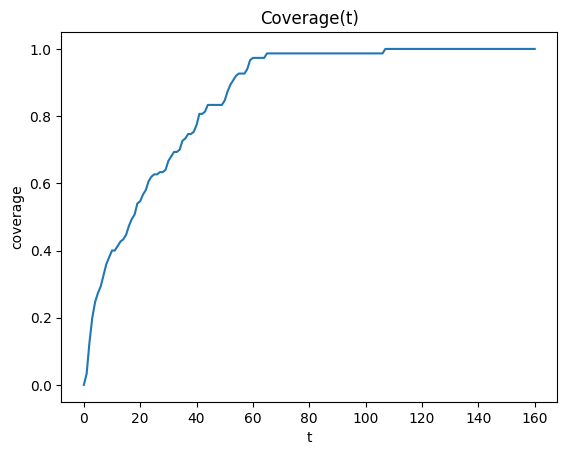

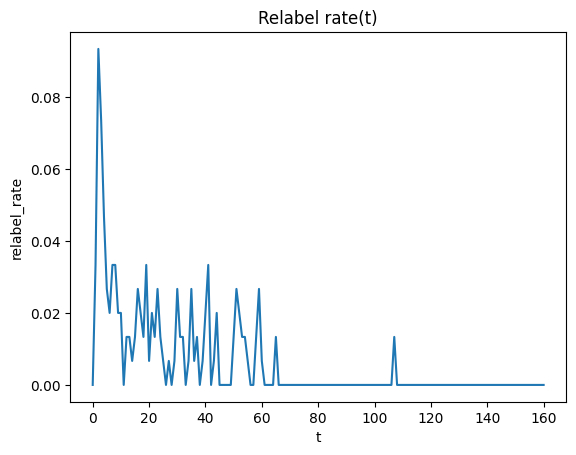

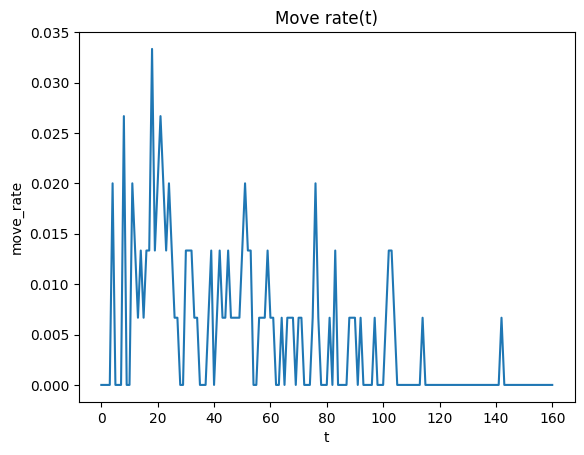

In [24]:
import matplotlib.pyplot as plt

def plot_online_log(online_log):
    """Grafica métricas online del algoritmo."""
    t = range(len(online_log["coverage"]))

    plt.figure()
    plt.plot(t, online_log["coverage"])
    plt.title("Coverage(t)")
    plt.xlabel("t")
    plt.ylabel("coverage")

    plt.figure()
    plt.plot(t, online_log["relabel_rate"])
    plt.title("Relabel rate(t)")
    plt.xlabel("t")
    plt.ylabel("relabel_rate")

    plt.figure()
    plt.plot(t, online_log["move_rate"])
    plt.title("Move rate(t)")
    plt.xlabel("t")
    plt.ylabel("move_rate")

    plt.show()

plot_online_log(online_log)


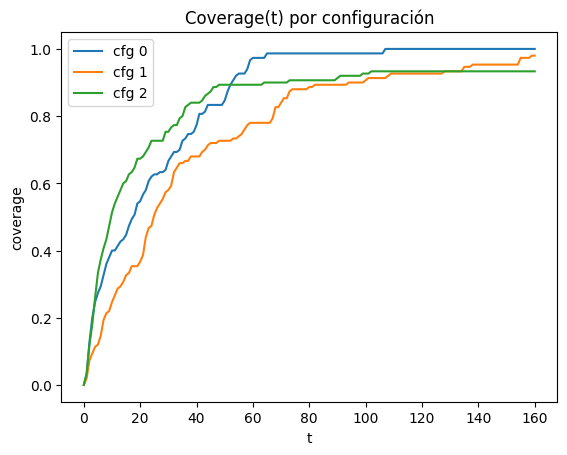

In [25]:
def compare_configs_online(X, y_true, configs, seed=0, record_every=5):
    """Compara cobertura online para varias configuraciones."""
    plt.figure()

    for i, params in enumerate(configs):
        y_pred, log = fit_predict(
            X,
            params | {"record_every": record_every},
            seed=seed,
            return_online=True
        )
        plt.plot(log["coverage"], label=f"cfg {i}")

    plt.title("Coverage(t) por configuración")
    plt.xlabel("t")
    plt.ylabel("coverage")
    plt.legend()
    plt.show()

top3 = df.sort_values("ari_mean", ascending=False).head(3)["params"].tolist()
compare_configs_online(X, y_true, top3, seed=0, record_every=5)
